# Final Project - Dog Breed Classification
 
Initial Models will be heavily borrowed from below Transfer Learning Keras Guides:

- https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
- https://keras.io/examples/vision/bit/


After training Classifiers on Stanford Dogs, Real-World Test Images will be used for inference, requiring resizing to ensure Test Resolutions match training Resolutions

- Learning to Resize in Computer Vision
    - https://keras.io/examples/vision/learnable_resizer/
- FixRes: Fixing train-test resolution discrepancy
    - https://keras.io/examples/vision/fixres/
    

TO Do - 

Exploratory Data Analysis 
	
    - make initial dog pictures better presented.
	- pick 5 clases, look at 9 dogs for each class.
    
    - bar chart of dog classes in Stanford Dataset and tsinghua dog dataset.
    - bar charts of how many images are:
        -face of dog vs whole body vs. action scene wtih cats etc.
        - if time permitting use YOLO on all 40,000 pics, if not take sub sample of 50 images and hand annotate.

	-from biology / family tree POV - which dogs are more closely related vs other breeds.
		- Family Tree picture from online
		- statistics overlap of DNA
        - https://www.quora.com/Is-there-a-family-tree-of-dog-breeds-that-we-can-trace-all-the-way-to-wolves
	
	- Turn Dog images into vectors and perform clustering
    
	-Issues with Stanford Dog Dataset not diverse
        - only includes Euro Centric Dog Breeds
        - does not include Dog Pictures from everyday life. 
        - artifical self portraits. 

	-Issues with Real World Dog Pictures
	-Consider the following: Hazy Picture / Low Light Picture / 
	-Image Cropping - picking out Dog from image.
		-(on power poin)
		-Use YOLO to create Boundary Bxoes around dogs. 
            -https://towardsdatascience.com/yolo-object-detection-with-opencv-and-python-21e50ac599e9
            
    
        
Retrain EFFICIENT Net on more diverse dog set - tsinghua dog dataset

OTHER:	


	-Confusion Matrix / classification Matrix (pull code from Assignment 6)
	- Display images of mis-classsified dogs
		- see if mis-classified dogs correlates to their family tree. 

SUPER INTERESTING:
	
    - discuss / implement how to feed a real world dog picture into our data pipeline.


In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns

import re

import matplotlib.pylab as plt


# from sklearn.model_selection import KFold
# import lightgbm as lgb
# from sklearn.metrics import mean_absolute_error
#plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=6144)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs


In [3]:
import tensorflow as tf
print(tf.__version__)

2.7.0


## Efficient Net
### Keras implementation - EfficientNetB0 for Stanford Dogs.

In [4]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
model = EfficientNetB0(include_top=False, weights='imagenet')

# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224

### Loading Data

-  Removing the MAX_PATH Limitation
    - https://docs.python.org/3/using/windows.html#removing-the-max-path-limitation
- Tensorflow Dataset API How To
    - https://kvirajdatt.medium.com/starting-with-tensorflow-datasets-part-2-intro-to-tfds-and-its-methods-32d3ac36420f
    - https://kvirajdatt.medium.com/starting-with-tensorflow-datasets-part-3-an-end-to-end-example-for-building-a-flowerclassifier-1b7c371447e1
    - https://towardsdatascience.com/how-to-use-dataset-in-tensorflow-c758ef9e4428

In [5]:
import tensorflow_datasets as tfds

batch_size = 64

dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, 
    split=["train", "test"], 
    with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes

#### Explore Stanford Dogs - TensorFlow Dataset

In [6]:
ds3 = ds_train.take(4)

for image, label in ds3:  # example is (image, label)
  print(image.shape, label)

(500, 333, 3) tf.Tensor(36, shape=(), dtype=int64)
(367, 400, 3) tf.Tensor(118, shape=(), dtype=int64)
(500, 375, 3) tf.Tensor(46, shape=(), dtype=int64)
(321, 450, 3) tf.Tensor(103, shape=(), dtype=int64)


#### Check Class Balance
    - 100 dogs per breed

In [7]:
label_y=[]

for X,y in ds_train.as_numpy_iterator():
#     print("Shape of X, y")
#     print(X.shape, y.shape)
#     print(type(X), ", This number is -->", y)
    #break # to avoid iterating over all the training examples
    label_y.append(y)

In [8]:
label_y=pd.DataFrame(label_y)
label_y.columns=['y']
## Training Dataset has 100 dogs per breed. 
#label_y['y'].value_counts()

#### Look at the Picture Dimensions and Resolution for each breed
    - Average Resolution for each class
    - Outlier Resolutions etc.
    - Do Bigger Dogs have less dots per inche vs big dogs?

In [9]:
resolution_list_1=[]
resolution_list_2=[]
for X,y in ds_train.as_numpy_iterator():
#     print("Shape of X, y")
#     print(X.shape, y)
    resolution_list_1.append(X.shape)
    resolution_list_2.append(y)
    #print(type(X), ", This number is -->", y)

In [10]:
resolution_list_1=pd.DataFrame(resolution_list_1)
resolution_list_1.columns=['width','height','channels']

resolution_list_2=pd.DataFrame(resolution_list_2)
resolution_list_2.columns=['breed']

resolution_list_1=resolution_list_1.drop('channels',1)
dog_boxes=pd.concat([resolution_list_1, resolution_list_2], axis=1, join="inner")

In [11]:
dog_boxes['box']=tuple(zip(dog_boxes['width'],dog_boxes['height']))

In [12]:
dog_boxes

,width,height,breed,box
0,500,333,36,"(500, 333)"
1,367,400,118,"(367, 400)"
2,500,375,46,"(500, 375)"
3,321,450,103,"(321, 450)"
4,333,500,113,"(333, 500)"
...,...,...,...,...
11995,330,440,35,"(330, 440)"
11996,375,500,111,"(375, 500)"
11997,375,500,86,"(375, 500)"
11998,500,333,60,"(500, 333)"


In [13]:
pd.set_option('display.max_rows', None)

#### Calculate the Box's Diagnol

In [14]:
dog_boxes['diag']=(dog_boxes['width'].pow(2) + dog_boxes['height'].pow(2)).pow(.5)
dog_boxes.head(5)

,width,height,breed,box,diag
0,500,333,36,"(500, 333)",600.740377
1,367,400,118,"(367, 400)",542.852650
2,500,375,46,"(500, 375)",625.000000
3,321,450,103,"(321, 450)",552.757632
4,333,500,113,"(333, 500)",600.740377


In [17]:
dog_boxes['breed_2']=dog_boxes['breed'].apply(lambda x: format_label(x))

In [18]:
dog_boxes.head(5)

,width,height,breed,box,diag,breed_2
0,500,333,36,"(500, 333)",600.740377,yorkshire_terrier
1,367,400,118,"(367, 400)",542.852650,dhole
2,500,375,46,"(500, 375)",625.000000,giant_schnauzer
3,321,450,103,"(321, 450)",552.757632,leonberg
4,333,500,113,"(333, 500)",600.740377,toy_poodle


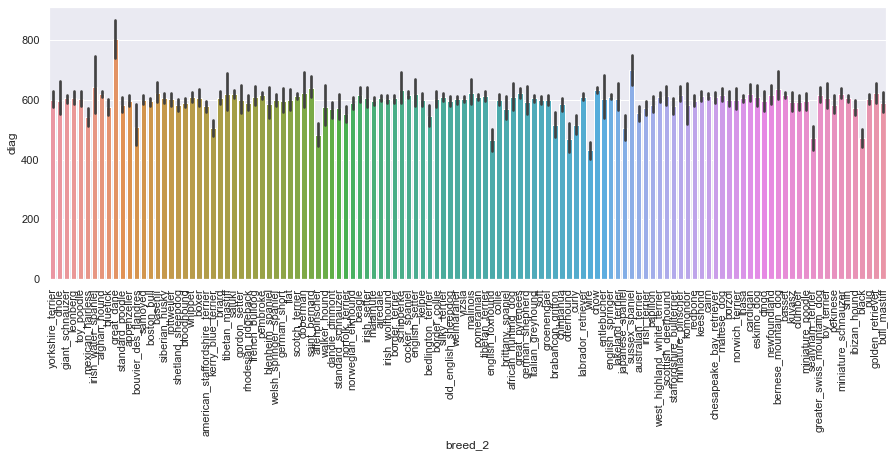

In [19]:
sns.set(rc = {'figure.figsize':(15,5)})
ax=sns.barplot(x="breed_2", y="diag", data=dog_boxes)

plt.xticks(rotation=90)
plt.show()

In [20]:
rez=dog_boxes['diag'].value_counts().to_frame().reset_index()
rez.columns = ['diag','ct']
#rez

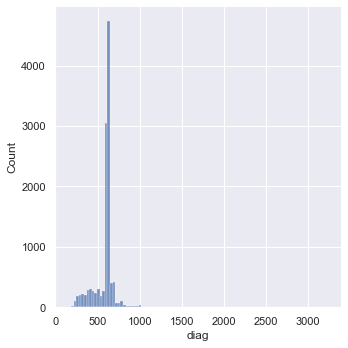

In [21]:
sns.displot(dog_boxes, x="diag", bins=100)

#### Look at the smallest and largest images

In [22]:
# ds3 = ds_train.take(11111)
# #.as_numpy_iterator()
# for image, label in ds3:  # example is (image, label)
#     plt.imshow(image.numpy().astype("uint8"))
#     #print(image.shape, label)

#### Use YOLO to determine Dog Portrait vs Real World Action Shot

In [ ]:
# ds3 = ds_train.take(11111)
# #.as_numpy_iterator()
# for image, label in ds3:  # example is (image, label)
#     plt.imshow(image.numpy().astype("uint8"))
#     #print(image.shape, label)

In [ ]:
# ds3 = ds_train.take(1695)
# #.as_numpy_iterator()
# for image, label in ds3:  # example is (image, label)
#     plt.imshow(image.numpy().astype("uint8"))
#     #print(image.shape, label)

In [ ]:
# ds3 = ds_train.take(15)
# #.as_numpy_iterator()
# for image, label in ds3:  # example is (image, label)
#     plt.imshow(image.numpy().astype("uint8"))
#     #print(image.shape, label)

#### Resize Images to input of EfficientNetB0

In [ ]:
# import tensorflow as tf
# size = (IMG_SIZE, IMG_SIZE)
# ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
# ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

#### Look at single Image in train tensorflow data set
    - https://stackoverflow.com/questions/56759226/how-to-access-feature-dictionaries-of-datasets-in-tensorflow
    - https://stackoverflow.com/questions/57518079/retrieving-the-next-element-from-tf-data-dataset-in-tensorflow-2-0-beta
    
    - TF DataSets Example:
        - https://www.tensorflow.org/datasets/overview

### Visualizing the data

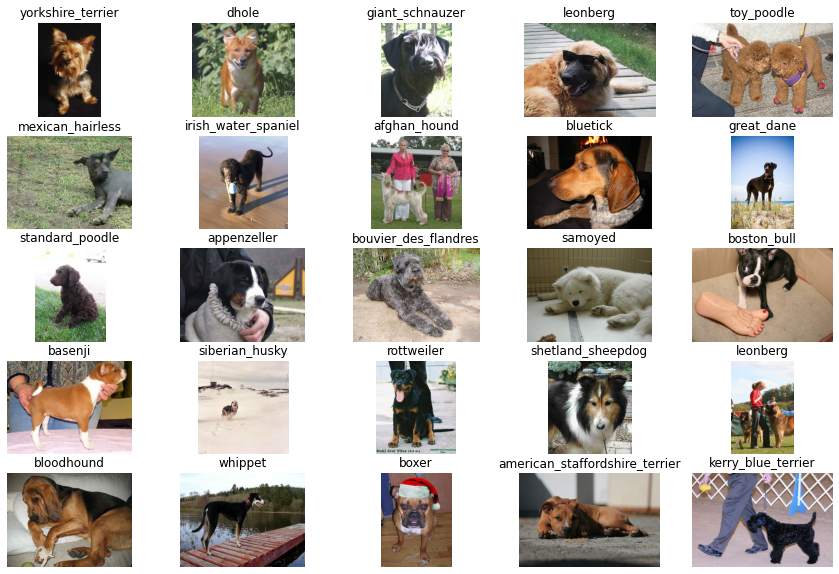

In [16]:
import matplotlib.pyplot as plt


def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]

fig, ax = plt.subplots(nrows=4, ncols=6, figsize=(15,10))

label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds_train.take(25)):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")

### Data Augmentation
 - Use of TF Data & Keras Img Aug Layers vs Image Data Generator
     - https://towardsdatascience.com/time-to-choose-tensorflow-data-over-imagedatagenerator-215e594f2435

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        #layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomZoom(height_factor=(0.15, 0.15), width_factor=(0.15, 0.15)),
        layers.RandomTranslation(0.1,0.1, fill_mode='reflect', interpolation='bilinear'),
        layers.RandomFlip("horizontal"),
        layers.RandomContrast(factor=0.15),
    ],
    name="img_augmentation",
)

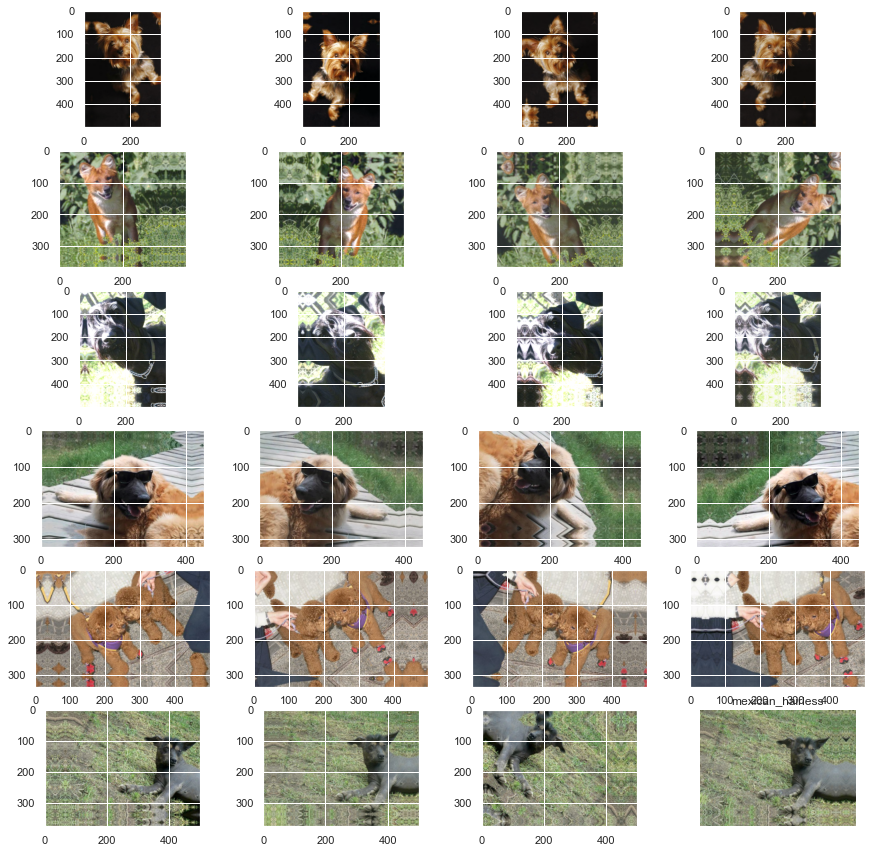

In [24]:
fig, ax = plt.subplots(nrows=6, ncols=4, figsize=(15,15))
i = 0

for image, label in ds_train.take(6):
    for j in range(4):
        #ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image, axis=0))
        #ax[i,j].imshow(imagge)
        ax[i,j].imshow(aug_img[0].numpy().astype("uint8"))
        #plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")
    i +=1

#### Resize Images to input of EfficientNetB0

In [25]:
import tensorflow as tf
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

### Prepare Inputs

In [26]:
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(
    input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)

https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/image_classification_efficientnet_fine_tuning.ipynb#scrollTo=NiKh6_3q9tib

### Transfer learning from pre-trained weights

In [27]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.25
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [ ]:
# model = build_model(num_classes=NUM_CLASSES)

In [ ]:
# from keras.utils.vis_utils import plot_model

# plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

#### Print Model Summary Here

In [ ]:
model = build_model(num_classes=NUM_CLASSES)

epochs = 5  # @param {type: "slider", min:8, max:80}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)

In [ ]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

### Unfreeze Model and Train with Tiny Learning Rate

In [ ]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-40:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

epochs = 20  # @param {type: "slider", min:8, max:50}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test)
plot_hist(hist)

#### Save Model to Disk
    - https://www.tensorflow.org/guide/keras/save_and_serialize

In [ ]:
#model.save('SF_EfficientNetB0.h5')

### Load Model from Disk for Inference

In [28]:
from tensorflow import keras
model_2=keras.models.load_model("SF_EfficientNetB0.h5")

### Inspect the output

Inspect the output and look at some examples it gets right, and some examples it gets wrong. The predict_classes function outputs the highest probability class according to the trained classifier for each input example.

#### Predicted classes

In [66]:
y_pred1[1]

array([2.29577353e-07, 3.23532667e-08, 2.41700828e-08, 3.78654590e-07,
       1.15903165e-09, 5.31831856e-10, 1.50534945e-07, 3.92569405e-07,
       1.40918883e-06, 4.92306640e-08, 5.28964117e-09, 1.55120787e-08,
       4.40016374e-05, 5.07727833e-08, 1.63162395e-06, 2.28607547e-07,
       2.67949673e-07, 1.56530166e-06, 3.10451256e-08, 1.33296192e-08,
       9.17590626e-09, 3.59824917e-08, 2.13475246e-08, 7.05544880e-05,
       5.01744921e-07, 5.22004626e-08, 2.80306622e-09, 1.18027010e-08,
       9.20733328e-07, 2.79021265e-06, 1.04931743e-08, 1.45009453e-05,
       3.28206013e-08, 7.03517458e-08, 4.90269258e-07, 1.57103113e-06,
       2.76037344e-08, 2.50589904e-09, 2.25689085e-08, 1.46262424e-08,
       5.72078079e-07, 8.45752038e-06, 1.51647484e-07, 1.17482291e-09,
       1.41960399e-07, 3.06071457e-09, 2.29218671e-08, 3.83140488e-08,
       7.10908610e-10, 5.57585000e-09, 3.40509928e-07, 1.28856970e-08,
       3.12169028e-08, 3.89048687e-08, 5.91461387e-08, 1.38235237e-07,
      

In [29]:
y_pred1 = model_2.predict(ds_test)
predicted_classes=np.argmax(y_pred1,axis=1)
print(predicted_classes)

[ 67  84  57 ...  95 111  25]


In [67]:
predicted_classes

array([ 67,  84,  57, ...,  95, 111,  25], dtype=int64)

In [30]:
type(predicted_classes)

numpy.ndarray

In [31]:
len(predicted_classes)

8576

In [32]:
predicted_classes[0]

67

In [33]:
format_label(predicted_classes[0])

'welsh_springer_spaniel'

##### Test Classes

In [34]:
# https://stackoverflow.com/questions/46902367/numpy-array-typeerror-only-integer-scalar-arrays-can-be-converted-to-a-scalar-i
#https://stackoverflow.com/questions/568962/how-do-i-create-an-empty-array-matrix-in-numpy

label_3=(np.empty(0,dtype=np.int64))
#dss = ds_test.take(8580)
dss = ds_test.take(8580)

for image, label in dss:
    #print(label.numpy())
    label_2=np.argmax(label,axis=1)
    #print(label_2)
    
    label_3=np.concatenate((label_3,label_2))

In [35]:
len(label_3)

8576

In [36]:
# from tensorflow.keras.datasets import mnist

# (x_train, y_train), (x_test, y_test) = mnist.load_data()
# x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
# y_pred1 = model.predict(x_test)
# predicted_classes=np.argmax(y_pred1,axis=1)
# print(predicted_classes)

# # Check which items we got right / wrong
# correct_indices = np.nonzero(predicted_classes == y_test)[0]
# incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

# #print(correct_indices)
# #print(incorrect_indices)

In [37]:
# #some of the correct results
# plt.figure(figsize=(10,10))
# for i, correct in enumerate(correct_indices[:9]):
#     plt.subplot(3,3,i+1)
#     plt.imshow(x_test[correct].reshape(28,28), cmap='gray', interpolation='none')
#     plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))
    
# #some of the incorrect predictions
# plt.figure(figsize=(10,10))
# for i, incorrect in enumerate(incorrect_indices[:9]):
#     plt.subplot(3,3,i+1)
#     plt.imshow(x_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
#     plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))

In [38]:
#'rhodesian_ridgeback' - 8

#shih - 4
format_label(4)

'shih'

In [39]:
# import time
# t_start = time.time()

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print(classification_report(label_3, predicted_classes))
print(confusion_matrix(label_3, predicted_classes))

# t_stop = time.time()
# print('Time elapsed: {:.3f} seconds'.format(t_stop - t_start))

              precision    recall  f1-score   support

           0       0.80      0.54      0.64        52
           1       0.79      0.86      0.82        85
           2       0.66      0.86      0.74       152
           3       0.83      0.71      0.77        49
           4       0.69      0.27      0.39       114
           5       0.96      0.81      0.88        88
           6       0.92      0.82      0.87        95
           7       0.65      0.67      0.66        72
           8       0.73      0.31      0.43        72
           9       0.93      0.90      0.92       139
          10       0.79      0.79      0.79        75
          11       0.78      0.65      0.71        95
          12       0.78      0.74      0.76        87
          13       0.74      0.61      0.67        71
          14       0.68      0.73      0.70        59
          15       0.46      0.53      0.49        53
          16       0.65      0.58      0.61        57
          17       0.50    

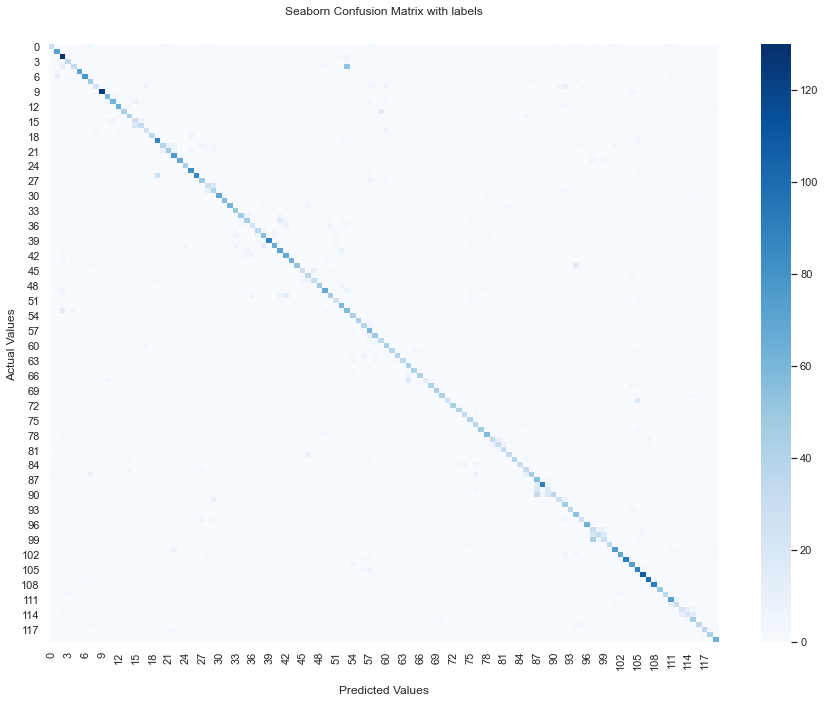

In [40]:
import seaborn as sns

sns.set(rc = {'figure.figsize':(15,11)})

#ax = sns.heatmap(confusion_matrix(label_3, predicted_classes), annot=True, cmap='Blues')
ax = sns.heatmap(confusion_matrix(label_3, predicted_classes), cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

#### Look Further into Classification Report

In [46]:
#https://stackoverflow.com/questions/39662398/scikit-learn-output-metrics-classification-report-into-csv-tab-delimited-format

report = classification_report(label_3, predicted_classes,output_dict=True)
df = pd.DataFrame(report).transpose()

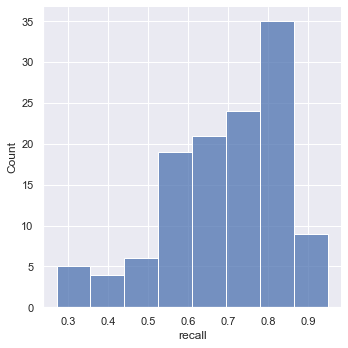

In [42]:
ax2=sns.displot(df, x="recall");
# ax2.set_title('Seaborn Confusion Matrix with labels\n\n');
# ax2.set_xlabel('\nPredicted Values')
# ax2.set_ylabel('Actual Values ');

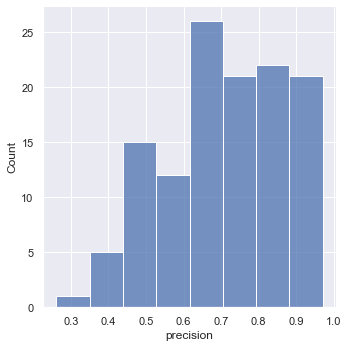

In [43]:
sns.displot(df, x="precision");

In [80]:
df_2=df.reset_index()
df_2.columns=['breed', 'precision', 'recall', 'f1-score', 'support']
df_2.drop(df_2.tail(3).index,
        inplace = True)
df_2['breed_2']=df_2['breed'].astype(int)
df_2['breed_3']=df_2['breed_2'].apply(lambda x: format_label(x))

In [81]:
df_2.pop('breed')
df_2.pop('breed_2')
df_2.head()

,precision,recall,f1-score,support,breed_3
0,0.800000,0.538462,0.643678,52.0,chihuahua
1,0.793478,0.858824,0.824859,85.0,japanese_spaniel
2,0.656566,0.855263,0.742857,152.0,maltese_dog
3,0.833333,0.714286,0.769231,49.0,pekinese
4,0.688889,0.271930,0.389937,114.0,shih


In [87]:
df_2.sort_values(by=['precision'], ascending=False).head(5)

,precision,recall,f1-score,support,breed_3
23,0.971014,0.697917,0.812121,96.0,norwegian_elkhound
43,0.969231,0.787500,0.868966,80.0,dandie_dinmont
5,0.959459,0.806818,0.876543,88.0,blenheim_spaniel
96,0.955224,0.914286,0.934307,70.0,saint_bernard
93,0.948718,0.711538,0.813187,52.0,tibetan_mastiff


In [86]:
df_2.sort_values(by=['precision']).head(5)

,precision,recall,f1-score,support,breed_3
97,0.260870,0.600000,0.363636,50.0,eskimo_dog
89,0.382979,0.352941,0.367347,51.0,appenzeller
29,0.393939,0.609375,0.478528,64.0,american_staffordshire_terrier
57,0.397351,0.845070,0.540541,71.0,labrador_retriever
53,0.423358,0.674419,0.520179,86.0,lhasa


In [84]:
df_2.sort_values(by=['recall'], ascending=False).head(5)

,precision,recall,f1-score,support,breed_3
108,0.834862,0.947917,0.887805,96.0,chow
119,0.901408,0.927536,0.914286,69.0,african_hunting_dog
94,0.568421,0.915254,0.701299,59.0,french_bulldog
96,0.955224,0.914286,0.934307,70.0,saint_bernard
106,0.775362,0.906780,0.835938,118.0,samoyed


In [85]:
df_2.sort_values(by=['recall']).head(5)

,precision,recall,f1-score,support,breed_3
4,0.688889,0.271930,0.389937,114.0,shih
99,0.466667,0.304348,0.368421,92.0,siberian_husky
8,0.733333,0.305556,0.431373,72.0,rhodesian_ridgeback
67,0.888889,0.320000,0.470588,50.0,welsh_springer_spaniel
89,0.382979,0.352941,0.367347,51.0,appenzeller
